In [1]:
import dlib
import glob
import cv2
import os
import sys
import  time
import numpy as np
import matplotlib.pyplot as plt
import pyautogui as pyg
import shutil

In [6]:
#data creation
# If cleanup is True then the new images and annotations will be appended to previous ones
# If False then all previous images and annotations will be deleted.
cleanup = False

# Set the window to a normal one so we can adjust it
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)

# Resize the window and adjust it to the center
# This is done so we're ready for capturing the images.
cv2.resizeWindow('frame', 1920,1080)
cv2.moveWindow("frame", 0,0)

# Initialize webcam
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)

# Initalize sliding window's x1,y1
x1 ,y1 = 0,0

# These will be the width and height of the sliding window.
window_width = 190#140  
window_height = 190

# We will save images after every 4 frames
# This is done so we don't have lot's of duplicate images
skip_frames = 3
frame_gap = 0

# This is the directory where our images will be stored
# Make sure to change both names if you're saving a different Detector
directory = 'train_images_h'
box_file = 'boxes_h.txt'

# If cleanup is True then delete all imaages and bounding_box annotations.
if cleanup:
    
    # Delete the images directory if it exists
    if os.path.exists(directory):
        shutil.rmtree(directory)
    
    # Clear up all previous bounding boxes
    open(box_file, 'w').close()
    
    # Initialize the counter to 0
    counter = 0
    
elif os.path.exists(box_file):

    # If cleanup is false then we must append the new boxes with the old
    with open(box_file,'r') as text_file:
        box_content = text_file.read()
        
    # Set the counter to the previous highest checkpoint
    counter = int(box_content.split(':')[-2].split(',')[-1])

# Open up this text file or create it if it does not exists
fr = open(box_file, 'a')

# Create our image directory if it does not exists.
if not os.path.exists(directory):
   os.mkdir(directory)

# Initial wait before you start recording each row
initial_wait = 0
        
# Start the loop for the sliding window
while(True):
    
    # Start reading from camera
    ret, frame = cap.read()
    if not ret:
        break
        
    # Invert the image laterally to get the mirror reflection.
    frame = cv2.flip( frame, 1 )
    
    # Make a copy of the original frame
    orig = frame.copy()    
    
    # Wait the first 50 frames so that you can place your hand correctly
    if initial_wait > 60:
        
        # Increment frame_gap by 1.
        frame_gap +=1  
    
        # Move the window to the right by some amount in each iteration.    
        if x1 + window_width < frame.shape[1]:
            x1 += 4
            time.sleep(0.1)            
            
        elif y1 + window_height + 270 < frame.shape[1]:

            # If the sliding_window has reached the end of the row then move down by some amount.
            # Also start the window from start of the row
            y1 += 80    
            x1 = 0

            # Setting frame_gap and init_wait to 0.
            # This is done so that the user has the time to place the hand correctly
            # in the next row before image is saved.
            frame_gap = 0
            initial_wait = 0
            
        # Break the loop if we have gone over the whole screen.
        else:
            break
              
    else: 
        initial_wait += 1

    # Save the image every nth frame.
    if frame_gap == skip_frames:

        # Set the image name equal to the counter value
        img_name = str(counter)  + '.png'

        # Save the Image in the defined directory
        img_full_name = directory + '/' + str(counter) +  '.png'
        cv2.imwrite(img_full_name, orig)
        
        # Save the bounding box coordinates in the text file.
        fr.write('{}:({},{},{},{}),'.format(counter, x1, y1, x1+window_width, y1+window_height))

        # Increment the counter 
        counter += 1

        # Set the frame_gap back to 0.
        frame_gap = 0

    # Draw the sliding window
    cv2.rectangle(frame,(x1,y1),(x1+window_width,y1+window_height),(0,255,0),3)
    
    # Display the frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
                break

# Release camera and close the file and window
cap.release()
cv2.destroyAllWindows()
fr.close()

In [7]:
# In this dictionary our images and annotations will be stored.**
data = {}
directory = 'train_images_h'
box_file = 'boxes_h.txt'

# Get the indexes of all images.
image_indexes = [int(img_name.split('.')[0]) for img_name in os.listdir(directory)]

# Shuffle the indexes to have random train/test split later on.
np.random.shuffle(image_indexes)

# Open and read the content of the boxes.txt file
f = open(box_file, "r")
box_content = f.read()

# Convert the bounding boxes to dictionary in the format `index: (x1,y1,x2,y2)` ...
box_dict =  eval( '{' +box_content + '}' )

# Close the file
f.close()

# Loop over all indexes
for index in image_indexes:
    
    # Read the image in memmory and append it to the list
    img = cv2.imread(os.path.join(directory, str(index) + '.png'))    
    
    # Read the associated bounding_box
    bounding_box = box_dict[index]
    
    # Convert the bounding box to dlib format
    x1, y1, x2, y2  = bounding_box
    dlib_box = [ dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2) ]
    
    # Store the image and the box together
    data[index] = (img, dlib_box)

In [8]:
print('Number of Images and Boxes Present: {}'.format(len(data)))

Number of Images and Boxes Present: 295


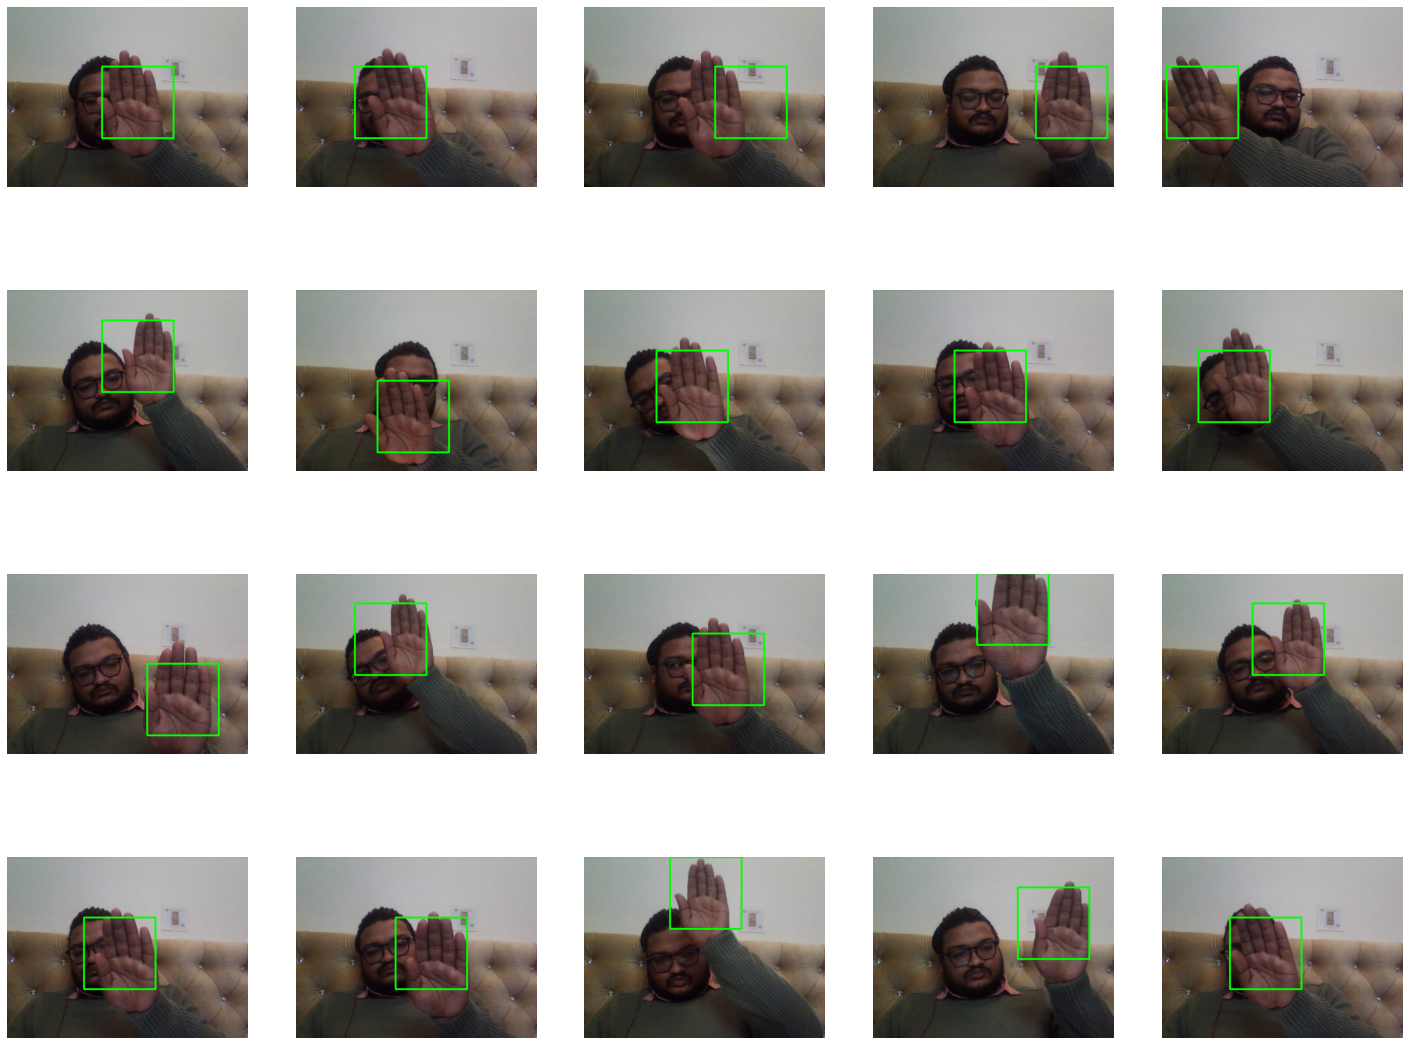

In [9]:
#viewing dta samples **
no_of_samples = 20

image_names = os.listdir(directory)

np.random.shuffle(data)

# Extract the subset of boxes
#subset = data[][:no_of_samples ]

cols = 5

# Given the number of samples to display, what's the number of rows required.
rows = int(np.ceil(no_of_samples / cols))

# Set the figure size
plt.figure(figsize=(cols*cols, rows*cols))

#Loop for each class
for i in range(no_of_samples):
        
        # Extract the bonding box coordinates
        d_box = data[i][1][0]
        left, top, right,bottom = d_box.left(), d_box.top(), d_box.right(), d_box.bottom()
        
        # Get the image
        image = data[i][0]
        
        # Draw reectangle on the detected hand
        cv2.rectangle(image,(left,top),(right,bottom),(0,255,0),3)
        
        # Display the image
        plt.subplot(rows,cols,i+1);plt.imshow(image[:,:,::-1]);plt.axis('off');

In [10]:
#training detector
# This is the percentage of data we will use to train
# The rest will be used for testing
percent = 0.8

# How many examples make 80%.
split = int(len(data) * percent)

# Seperate the images and bounding boxes in different lists.
images = [tuple_value[0] for tuple_value in data.values()]
bounding_boxes = [tuple_value[1] for tuple_value in data.values()]

# Initialize object detector Options
options = dlib.simple_object_detector_training_options()

# I'm disabling the horizontal flipping, becauase it confuses the detector if you're training on few examples
# By doing this the detector will only detect left or right hand (whichever you trained on). 
options.add_left_right_image_flips = False

# Set the c parameter of SVM equal to 5
# A bigger C encourages the model to better fit the training data, it can lead to overfitting.
# So set an optimal C value via trail and error.
options.C = 5

# Note the start time before training.
st = time.time()

# You can start the training now
detector = dlib.train_simple_object_detector(images[:split], bounding_boxes[:split], options)

# Print the Total time taken to train the detector
print('Training Completed, Total Time taken: {:.2f} seconds'.format(time.time() - st))

Training Completed, Total Time taken: 70.32 seconds


In [11]:
file_name = 'Head_Detector.svm'
detector.save(file_name)

In [14]:
win_det = dlib.image_window()
win_det.set_image(detector)

In [13]:
print("Training Metrics: {}".format(dlib.test_simple_object_detector(images[:split], bounding_boxes[:split], detector)))
print("Testing accuracy: {}".format(dlib.test_simple_object_detector(images[split:], bounding_boxes[split:], detector)))

Training Metrics: precision: 0.964758, recall: 0.927966, average precision: 0.917402
Testing accuracy: precision: 0.931034, recall: 0.915254, average precision: 0.89432


In [17]:
#testing trained detector**
file_name = 'Hand_Detector.svm'

# Load our trained detector 
detector = dlib.simple_object_detector(file_name)

# Set the window name
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)

# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0

# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0

# Initialize these variables for calculating FPS
fps = 0 
frame_counter = 0
start_time = time.time()

# Set the while loop
while(True):
    
    # Read frame by frame
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Laterally flip the frame
    frame = cv2.flip( frame, 1 )
    
    # Calculate the Average FPS
    frame_counter += 1
    fps = (frame_counter / (time.time() - start_time))
    
    # Create a clean copy of the frame
    copy = frame.copy()  
    
    # Downsize the frame.
    new_width = int(frame.shape[1]/scale_factor)
    new_height = int(frame.shape[0]/scale_factor)
    resized_frame = cv2.resize(copy, (new_width, new_height))
    
    # Detect with detector
    detections = detector(resized_frame)
    
    # Loop for each detection.
    for detection in (detections):    
        
        # Since we downscaled the image we will need to resacle the coordinates according to the original image.
        x1 = int(detection.left() * scale_factor )
        y1 =  int(detection.top() * scale_factor )
        x2 =  int(detection.right() * scale_factor )
        y2 =  int(detection.bottom()* scale_factor )
        
        # Draw the bounding box
        cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
        cv2.putText(frame, 'Hand Detected', (x1, y2+20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)

        # Calculate size of the hand. 
        size = int( (x2 - x1) * (y2-y1) )
        
        # Extract the center of the hand on x-axis.
        center_x = x2 - x1 // 2
    
    # Display FPS and size of hand
    cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (20, 20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)

    # This information is useful for when you'll be building hand gesture applications
    cv2.putText(frame, 'Center: {}'.format(center_x), (540, 20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (233, 100, 25))
    cv2.putText(frame, 'size: {}'.format(size), (540, 40), cv2.FONT_HERSHEY_COMPLEX, 0.5, (233, 100, 25))
    
    # Display the image
    cv2.imshow('frame',frame)
                  
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Relase the webcam and destroy all windows
cap.release()
cv2.destroyAllWindows()

In [16]:
# Set these thresholds accordingly.***

# If hand size is larger than this then up, button is triggered
size_up_th = 80000

# If hand size is smaller than this then down key is triggered
size_down_th = 25000

# If the center_x location is less than this then left key is triggered
left = 160

# If the center_x location is greater than this then right key is triggered
right = 480

# Load our trained detector 
detector = dlib.simple_object_detector('Hand_Detector.svm')

# Set the window to normal
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)

# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0

# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0

# Initialize these variables for calculating FPS
fps = 0 
frame_counter = 0
start_time = time.time()

# Set the while loop
while(True):
    
    # Read frame by frame
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Laterally flip the frame
    frame = cv2.flip( frame, 1 )
    
    # Calculate the Average FPS
    frame_counter += 1
    fps = (frame_counter / (time.time() - start_time))
    
    # Create a clean copy of the frame
    copy = frame.copy()  
    
    # Downsize the frame.
    new_width = int(frame.shape[1]/scale_factor)
    new_height = int(frame.shape[0]/scale_factor)
    resized_frame = cv2.resize(copy, (new_width, new_height))
    
    # Detect with detector
    detections = detector(resized_frame)
    
    # Set Default values
    text = 'No Hand Detected'
    center_x = 0
    size = 0

    # Loop for each detection.
    for detection in (detections):    
        
        # Since we downscaled the image we will need to resacle the coordinates according to the original image.
        x1 = int(detection.left() * scale_factor )
        y1 =  int(detection.top() * scale_factor )
        x2 =  int(detection.right() * scale_factor )
        y2 =  int(detection.bottom()* scale_factor )
        
        # Calculate size of the hand. 
        size = int( (x2 - x1) * (y2-y1) )
        
        # Extract the center of the hand on x-axis.
        center_x = int(x1 + (x2 - x1) / 2)
        
        # Draw the bounding box of the detected hand
        cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
        
        # Now based on the size or center_x location set the required text
        if center_x > right:
            text = 'Right'

        elif center_x < left:
            text = 'Left'

        elif size > size_up_th:
            text = 'Up'

        elif size < size_down_th:
            text = 'Down'
            
        else:
            text = 'Neutral'
            
    # Now we should draw lines for left/right threshold
    cv2.line(frame, (left,0),(left, frame.shape[0]),(25,25,255), 2)
    cv2.line(frame, (right,0),(right, frame.shape[0]),(25,25,255), 2)    

    # Display Center_x value and size.
    cv2.putText(frame, 'Center: {}'.format(center_x), (500, 20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (233, 100, 25), 1)
    cv2.putText(frame, 'size: {}'.format(size), (500, 40), cv2.FONT_HERSHEY_COMPLEX, 0.6, (233, 100, 25))

    # Finally display the text showing which key should be triggered
    cv2.putText(frame, text, (220, 30), cv2.FONT_HERSHEY_COMPLEX, 0.7, (33, 100, 185), 2)

    # Display the image
    cv2.imshow('frame',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Relase the webcam and destroy all windows
cap.release()
cv2.destroyAllWindows()            

In [ ]:
# Load our trained detector 
detector = dlib.simple_object_detector('Hand_Detector.svm')

# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0

# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0

# Initialize these variables for calculating FPS
fps = 0 
frame_counter = 0
start_time = time.time()

# Set Player = True in order to use this script for the VLC video palyer
player = True

# This variable is True when we press a key and False when there is no detection.
# Its only used in the video Player
status = False

# We're recording the whole screen to view it later
screen_width, screen_height = tuple(pyg.size())
out = cv2.VideoWriter(r'videorecord.mp4', cv2.VideoWriter_fourcc(*'XVID'), 15.0, (screen_width,screen_height ))

# Set the while loop
while(True):
    
    try:
    
        # Read frame by frame
        ret, frame = cap.read()

        if not ret:
            break

        # Laterally flip the frame
        frame = cv2.flip( frame, 1 )

        # Calculate the Average FPS
        frame_counter += 1
        fps = (frame_counter / (time.time() - start_time))

        # Create a clean copy of the frame
        copy = frame.copy()  

        # Downsize the frame.
        new_width = int(frame.shape[1]/scale_factor)
        new_height = int(frame.shape[0]/scale_factor)
        resized_frame = cv2.resize(copy, (new_width, new_height))

        # Detect with detector
        detections = detector(resized_frame)
        
        # Key will initially be None
        key = None

        if len(detections) > 0:
            
            # Grab the first detection
            detection = detections[0]

            # Since we downscaled the image we will need to resacle the coordinates according to the original image.
            x1 = int(detection.left() * scale_factor )
            y1 =  int(detection.top() * scale_factor )
            x2 =  int(detection.right() * scale_factor )
            y2 =  int(detection.bottom()* scale_factor )
            
            cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
            cv2.putText(frame, 'Hand Detected', (x1, y2+20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)

            # Calculate size of the hand. 
            size = int( (x2 - x1) * (y2-y1) )

            # Extract the center of the hand on x-axis.
            center_x = int(x1 + (x2 - x1) / 2)

            # Press the requird button based on center_x location and size   
            # The behaviour of keys will be different depending upon if we're controlling a game or a video player.
            # The status variable makes sure we do not double press the key in case of a video player.

            if center_x > right:
                
                key = 'right'
                if player and not status:
                    pyg.hotkey('ctrl', 'right') 
                    status = True

            elif center_x < left:
                
                key = 'left'               
                if player and not status:
                    pyg.hotkey('ctrl', 'left')
                    status = True

            elif size > size_up_th:
                
                key = 'up'
                if player and not status:
                    pyg.press('space')
                    status = True

            elif size < size_down_th:
                key = 'down'
            
            # Check if we're playing a game then press the requried key
            if key is not None and player == False:                
                    pyg.press(key)            
        
        # If there was'nt a detection then status is made False
        else:
            status = False
        
        
        # Capture the screen
        image = pyg.screenshot()
        
        # Convert to BGR, numpy array (Opencv format of image)
        img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        
        # Resize the camera frame and attach it to screen.
        resized_frame = cv2.resize(frame, (0,0), fx=0.6, fy=0.6)
        h = resized_frame.shape[0]
        w = resized_frame.shape[1]
        img[0:h, 0:w]  = resized_frame
        
        # Save the video frame
        out.write(img)
        
        #time.sleep(0.2)
    except KeyboardInterrupt:
        print('Releasing the Camera and exiting since the program was stopped')
        cap.release()
        out.release()
        sys.exit()

In [ ]:
# Release the camera and the videowriter if the code above exited from an exception other than KeyboardInterrupt
cap.release()
out.release()